# Model 2: TimeSeries

## Input :
- receivals.csv
## Serie for each raw material
- net weight delivered each day from 2014 to 2024
- fill with 0 when no deliverie

## Forcasting with a model
- SARIMA Model
- Holt–Winters Model
- AI model 

## Output
- submission File


observation of a big change in 2012 -> start data after 2012 
-> wrong observation, for some deliveries the beginning of these deliveries start later.
-> Try to change the starting date for each TS (First deliverie starts the TS)

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

# HyperParameters

In [13]:
history_start_date = "2004-01-01"
Positive_Deliveries = True #Set 0 for negative deliveries
weekend0 = True #Set 0 for positive deliveries during the weekend
seasonality = 7 #=  One week -> year, month is too long (bad results)
forecast_start = pd.Timestamp("2025-01-01")
forecast_end   = pd.Timestamp("2025-05-31")


# A) Data Fitting

In [14]:
receivals = pd.read_csv('./data/kernel/receivals.csv')

receivals = receivals.dropna(subset=["net_weight"])
receivals = receivals[receivals["net_weight"] > 0]
#df_nan = receivals[receivals["net_weight"].isna()]

receivals['date_arrival'] = (
    pd.to_datetime(receivals['date_arrival'], utc=True)
      .dt.tz_localize(None)
      .dt.normalize()
)

receivals = receivals[receivals["date_arrival"] >= pd.Timestamp(history_start_date)].reset_index(drop=True)
print(receivals['date_arrival'][0])

daily = (
    receivals.groupby(["rm_id","date_arrival"], as_index=False)
             .agg(
                 net_weight_sum=("net_weight", "sum")
             ).rename(columns={"date_arrival": "date","net_weight_sum":"net_weight"})
             .sort_values(["rm_id","date"])
)

print(len(daily))
print(daily.head(10))

2004-06-15 00:00:00
41906
   rm_id       date  net_weight
0  342.0 2004-06-23     24940.0
1  343.0 2005-03-29     21760.0
2  345.0 2004-09-01     22780.0
3  346.0 2004-06-24       820.0
4  346.0 2004-06-30     21260.0
5  346.0 2004-07-28      2880.0
6  347.0 2004-06-17     29805.0
7  347.0 2004-06-21     14920.0
8  347.0 2004-07-28     11200.0
9  347.0 2004-09-03     20220.0


### a) Remove and stock Outliers (Rare occurrences)

In [15]:
stats = (
    daily.groupby("rm_id")
            .agg(
                last_delivery=("date", "max"),
                total_deliveries=("date", "count")  # number of delivery-days
            )
)
cutoff = pd.Timestamp("2024-12-31") - pd.DateOffset(years=5)

rare_rm_id = stats.index[(stats["last_delivery"] <= cutoff) | (stats["total_deliveries"] <= 3)]

print(f"We don't have enough information to forecast the following rm_id :\n{rare_rm_id}")


We don't have enough information to forecast the following rm_id :
Index([ 342.0,  343.0,  345.0,  346.0,  347.0,  348.0,  353.0,  354.0,  355.0,
        357.0,
       ...
       4101.0, 4161.0, 4343.0, 4381.0, 4401.0, 4461.0, 4462.0, 4463.0, 4481.0,
       4501.0],
      dtype='float64', name='rm_id', length=133)


In [16]:
# I remove rare_rm_id 
daily = daily[~daily["rm_id"].isin(rare_rm_id)].reset_index(drop=True)

### b) Fill missing days with the value 0

In [17]:

# 3) Build the full MultiIndex (all rm_id x all days in the range)
full_start = pd.Timestamp(history_start_date)
full_end   = pd.Timestamp("2024-12-31")
rm_ids = pd.Index(daily["rm_id"].unique(), name="rm_id")
calendar = pd.date_range(full_start, full_end, freq="D", name="date")
full_idx = pd.MultiIndex.from_product([rm_ids, calendar], names=["rm_id","date"])

# 4) Reindex to the full grid and fill missing with 0
daily = (
    daily.set_index(["rm_id","date"])["net_weight"]
         .reindex(full_idx, fill_value=0)
         .reset_index()
)

#-------------------------------------------------------------------------------------------------------
# Calculate the 7-day rolling mean, grouped by 'rm_id'
daily = daily.sort_values(["rm_id", "date"])
daily["net_weight"] = daily.groupby("rm_id")["net_weight"].transform(
    lambda x: x.rolling(window=7, min_periods=1).mean()
)
#-------------------------------------------------------------------------------------------------------


print(daily.head(5))

top_rm_ids = daily.groupby('rm_id')['net_weight'].sum().nlargest(5).index
print(f"Top rm_ids are : {top_rm_ids}")

    rm_id       date  net_weight
0  2121.0 2004-01-01         0.0
1  2121.0 2004-01-02         0.0
2  2121.0 2004-01-03         0.0
3  2121.0 2004-01-04         0.0
4  2121.0 2004-01-05         0.0
Top rm_ids are : Index([2130.0, 2160.0, 2140.0, 3126.0, 3781.0], dtype='float64', name='rm_id')


# B) Model Training

### a) Training test on one rm_id

rm_id test : 2130.0, 4263.0

In [18]:
rm = 2130.0

# 1) build a daily series with explicit daily freq
series = (
    daily.loc[daily["rm_id"] == rm, ["date", "net_weight"]]
            .set_index("date")["net_weight"]
            .asfreq("D")
)

# 2) fit SARIMAX (additive handles zeros safely)
model = SARIMAX(
    series,
    order=(2, 1, 1),          # Non-seasonal (p, d, q)
    seasonal_order=(1, 0, 1, 7)  # Seasonal (P, D, Q, S)
).fit(disp=True)

# 3) predict using calendar dates (works because the index has freq='D')
fc = model.predict(start=forecast_start, end=forecast_end)

pred = (
    fc.rename("net_weight")
        .reset_index()
        .rename(columns={"index": "date"})
)
if Positive_Deliveries:
    pred["net_weight"] = pred["net_weight"].clip(lower=0)

# assign value 0 for the weekend
if weekend0:
    pred['day_of_week'] = pred['date'].dt.dayofweek
    pred.loc[pred['day_of_week'].isin([5, 6]), 'net_weight'] = 0
    pred = pred.drop(columns=['day_of_week'])


c:\Users\julie\miniforge3\envs\conda1\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


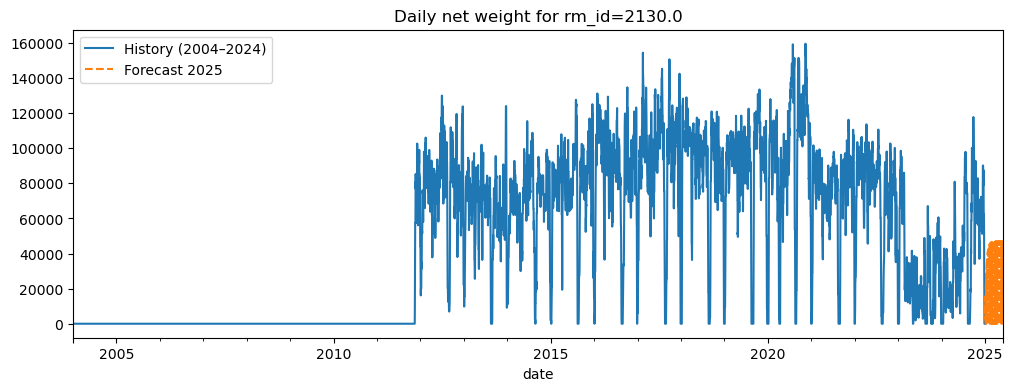

In [19]:
history = daily[(daily["rm_id"] == rm)].set_index("date")["net_weight"]
future = pred.set_index("date")["net_weight"]

plt.figure(figsize=(12,4))
history.plot(label="History (2004–2024)")
future.plot(label="Forecast 2025", style="--")
plt.title(f"Daily net weight for rm_id={rm}")
plt.legend()
plt.show()



<Figure size 1200x600 with 0 Axes>

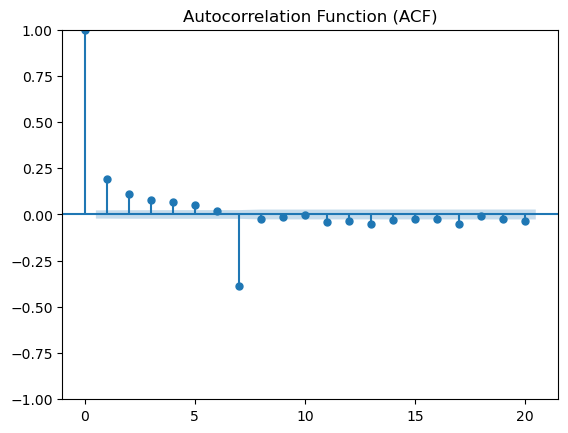

<Figure size 1200x600 with 0 Axes>

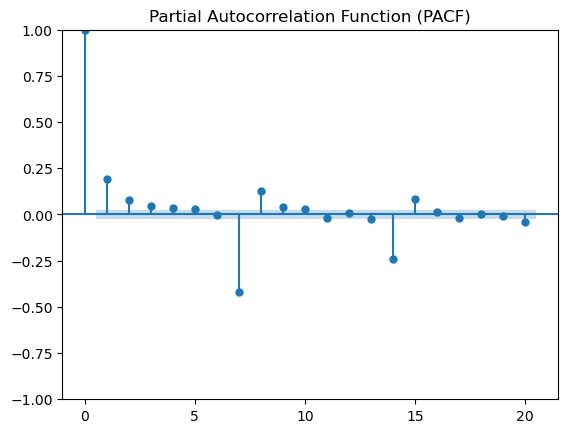

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Plot ACF
diff_series = series.diff().dropna()
plt.figure(figsize=(12, 6))
plot_acf(diff_series, lags=20, alpha=0.05)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(diff_series, lags=20, alpha=0.05, method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [21]:

# Extract the day of the week (Monday=0, Sunday=6)
pred['day_of_week'] = pred['date'].dt.dayofweek

# Map the day number to day name for clarity

# Group by day of the week and sum the net_weight
deliveries_by_day = pred.groupby('day_of_week')['net_weight'].sum().reset_index()

# Display the result
print(deliveries_by_day)

   day_of_week     net_weight
0            0  918242.815500
1            1  928834.867669
2            2  940332.242971
3            3  950101.404978
4            4  958167.046579
5            5       0.000000
6            6       0.000000


### b) Real Training

In [22]:

predictions = []

for rm in daily["rm_id"].unique():
    # 1) build a daily series with explicit daily freq
    series = (
        daily.loc[daily["rm_id"] == rm, ["date", "net_weight"]]
                .set_index("date")["net_weight"]
                .asfreq("D")
    )
 
    # 2) fit Holt–Winters (additive handles zeros safely)

    model = SARIMAX(
        series,
        order=(1, 1, 1),          # Non-seasonal (p, d, q)
        seasonal_order=(1, 0, 1, 7)  # Seasonal (P, D, Q, S)
    ).fit(maxiter=50)

    # 3) predict using calendar dates (works because the index has freq='D')
    fc = model.predict(start=forecast_start, end=forecast_end)

    pred = (
        fc.rename("net_weight")
            .reset_index()
            .rename(columns={"index": "date"})
    )
    if Positive_Deliveries:
        pred["net_weight"] = pred["net_weight"].clip(lower=0)

    # assign value 0 for the weekend
    if weekend0:
        pred['day_of_week'] = pred['date'].dt.dayofweek
        pred.loc[pred['day_of_week'].isin([5, 6]), 'net_weight'] = 0
        pred = pred.drop(columns=['day_of_week'])

    pred["rm_id"] = rm
    
    predictions.append(pred)

# 5) all rm_id forecasts
df_forecast = pd.concat(predictions, ignore_index=True)

# output : df_forecast contains the forecasting data for not rare rm_id

c:\Users\julie\miniforge3\envs\conda1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\julie\miniforge3\envs\conda1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\julie\miniforge3\envs\conda1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\julie\miniforge3\envs\conda1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting 

# C) Output, Submission file creation

In [23]:

# input dataframe : contains all rm_id, net_weight_sum and date (at least these three columns)
# name of the parameter : df_final
def print_submission(df_final, filename="submission.csv"):

    df_final["rm_id"] = pd.to_numeric(df_final["rm_id"], errors="coerce").astype("Int64")

    # 3) Load the ID mapping
    ids = pd.read_csv("./data/prediction_mapping.csv")  # or your actual path
    ids["forecast_start_date"] = pd.to_datetime(ids["forecast_start_date"])
    ids["forecast_end_date"]   = pd.to_datetime(ids["forecast_end_date"])
    ids["rm_id"]    = pd.to_numeric(ids["rm_id"], errors="coerce").astype("Int64")
    ids = ids.rename(columns={
        "forecast_end_date": "date"
    })

    # 4) For each ID, get cum at end_date (<= end_date)

    out = (
        ids.merge(df_final, on=["rm_id", "date"], how="left")
        .assign(cum=lambda d: d["cum"].fillna(0))   # cum=0 quand absent
        .sort_values(["rm_id", "date"])
        .reset_index(drop=True)
    )


    # 5) Cum at day before start_date
    submission = (
        out[["ID", "cum"]]
        .rename(columns={"cum": "predicted_weight"})   # if your file needs "predicted_weight"
        .fillna({"predicted_weight": 0})
        .sort_values("ID")
    )

    submission.to_csv("./submissions/" + filename, index=False)
    print(submission.head())

### a) Calcul of cumsum net weight and final file

- Do cumsum
- Fill with rare_rm_id with 0

In [24]:
#Fichier des predictions
df_cum  = (
    df_forecast.sort_values(["rm_id", "date"])
        .groupby("rm_id", as_index=False)
        .apply(lambda g: g.assign(cum=g["net_weight"].cumsum()))
        .reset_index(drop=True)
        [["rm_id", "date", "cum"]]
)

# 2) ajout des valeurs nulles 
dates = pd.date_range("2025-01-01", "2025-05-03", freq="D")

df_new  = (
    pd.MultiIndex.from_product([rare_rm_id, dates], names=["rm_id", "date"])
      .to_frame(index=False)
      .assign(cum=0)
)
df_final = pd.concat([df_cum, df_new], ignore_index=True)



C:\Users\julie\AppData\Local\Temp\ipykernel_19988\1328190363.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.assign(cum=g["net_weight"].cumsum()))


### b) creation submission

In [25]:
print_submission(df_final,filename="SARIMA_s7.csv")

      ID  predicted_weight
2100   1               0.0
2101   2               0.0
2102   3               0.0
2103   4               0.0
2104   5               0.0
